<a href="https://colab.research.google.com/github/rakeshsiri/data-x-2-lab/blob/master/Report_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Akbar Surani

Anmol Dureha

Pradeep Kumar

Rakesh Siri

.............

Final Project Report - Part 2

Data-X 2

12th December, 2020

# Pivoted from here

As a team, we pivoted from our earlier problem of movie summarization. With the aim to gather a well structured and clean dataset, we explored several datasets and finally selected the South Park Cartoon Dialogues dataset. South Park is a cartoon show. The dataset features 18 seasons of this show and has 70,000+ utterances or dialogues. This dataset is in the format that allows us to perform analyses or solve problems based on characters. The two problems that we are aiming to tackle using this dataset are:

1. Predicting the speaker (Quotes -> Speaker)
In this task, we train the model and then provide a dialogue as an input. The model's performance is then evaluated based on how accurately it can predict the speaker of that particular dialogue. Here, the input is a quote or a dialogue and the output is one of the characters from the show.

2. Quote Generation (Speaker -> Quote)
In this task, we input the name of the character we want to generate a dialogue for. The generated dialogue is expected to be in the way the mentioned character usually speaks. This required learning from many dialogues spoken by that particular character in the show. 

# Exploratory Data Analysis

Let us first start with performing an exploratory data analyses of the South Park dialogues data. 

In [0]:
import numpy as np 
import pandas as pd 
import plotly.offline as offline
import plotly.graph_objs as go
import nltk
import plotly.offline as offline
import plotly.graph_objs as go
import random
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer
nltk.download('stopwords')
nltk.download('punkt')
from subprocess import check_output
from math import log
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Import the dataset and explore it below. 

In [0]:
df = pd.read_csv('All-seasons.csv')

In [0]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70896 entries, 0 to 70895
Data columns (total 4 columns):
Season       70896 non-null object
Episode      70896 non-null object
Character    70896 non-null object
Line         70896 non-null object
dtypes: object(4)
memory usage: 2.2+ MB


In [0]:
df.head()

,Season,Episode,Character,Line
0,10,1,Stan,"You guys, you guys! Chef is going away. \n"
1,10,1,Kyle,Going away? For how long?\n
2,10,1,Stan,Forever.\n
3,10,1,Chef,I'm sorry boys.\n
4,10,1,Stan,"Chef said he's been bored, so he joining a gro..."


In [0]:
df.describe()

,Season,Episode,Character,Line
count,70896,70896,70896,70896
unique,19,19,3950,64301
top,2,10,Cartman,What?\n
freq,6416,5271,9774,361


First of all, we are interested to see the analysis of the occurence of various words. Through our observation from watching the show, the word 'cool' has been used extensively in the whole show, so let's see how often this word is being used in the whole show. 

We are also interested in knowing season-wise or episode-wise occurence of words. A particular word may be used more often in one season than in another, and we may find something interesting by analyzing this. To do so, we write a function that counts the occurences of a word in the whole show, in any particular seasons, or in any particular episodes.

We are also interested in seeing which character speaks a particular word in the given season or episode, so we include that as well in our functions.


In [0]:
MAX_SEASON = 18

def word_count_by_season_and_episode(df, word, character="", seasons=[], episodes=[]):
    count = 0
    character = character.lower()
    word = word.lower()

    for idx, row in df.iterrows():

        # When the input argument doesn't involve seasons or episodes, then we just calculate the number of occurences of the word throughout the show
        if seasons == [] and episodes == []:
            if character == "":
                if word in row['Line'].lower():
                    split_line = row['Line'].split()
                    for w in split_line:
                        if word in w.lower():
                            count += 1
            else:
                if word in row['Line'].lower() and character in row['Character'].lower():
                    split_line = row['Line'].split()
                    for w in split_line:
                        if word in w.lower():
                            count += 1

        # When the input argument involves seasons, but not episodes, we just calculate the number of occurences of the word by seasons
        elif seasons != [] and episodes == []:
            if character == "":
                if any(season == row['Season'] for season in seasons) and word in row['Line'].lower():
                    split_line = row['Line'].split()
                    for w in split_line:
                        if word in w.lower():
                            count += 1
            else:
                if any(season == row['Season'] for season in seasons) and word in row['Line'].lower() and character in row['Character'].lower():
                    split_line = row['Line'].split()
                    for w in split_line:
                        if word in w.lower():
                            count += 1

        # When the input argument involves seasons as well as episodes, we calculate the number of occurences of the word by seasons & episodes
        else:
            if character == "":
                if any(season == row['Season'] for season in seasons) and any(episode == row['Episode'] for episode in episodes) and word in row['Line'].lower():
                    split_line = row['Line'].split()
                    for w in split_line:
                        if word in w.lower():
                            count += 1
            else:
                if any(season == row['Season'] for season in seasons) and any(episode == row['Episode'] for episode in episodes) and word in row['Line'].lower() and character in row['Character'].lower():
                    split_line = row['Line'].split()
                    for w in split_line:
                        if word in w.lower():
                            count += 1
    return count

df = pd.read_csv('All-seasons.csv')

In [0]:
print(word_count_by_season_and_episode(df, word="cool"))

596


In [0]:
print(word_count_by_season_and_episode(df, word="cool", seasons=['1'], episodes=['1','2']))

5


Let us now visualize the occurence of some of the most used words (that are not stop words) in the show. This shows us the kind of language being used in the show.

In [0]:
def plot_swear_count_season_frequency():

    dumbass = [152, 207, 269, 189, 147, 164, 136, 123, 99, 125, 122, 78, 96, 61, 117, 110, 48, 62]
    damn = [100, 115, 104, 79, 77, 79, 64, 54, 53, 50, 38, 45, 37, 32, 28, 26, 17, 23] # damn or dammit
    bullshit = [5, 21, 10, 7, 168, 25, 16, 7, 7, 4, 35, 10, 18, 21, 116, 30, 30, 44]

    trace1 = go.Scatter(
        x=['S-1', 'S-2', 'S-3', 'S-4', 'S-5', 'S-6', 'S-7', 'S-8', 'S-9', 'S-10', 'S-11', 'S-12', 'S-13', 'S-14', 'S-15', 'S-16', 'S-17', 'S-18'],
        y=dumbass,
        mode='lines+markers',
        name="'Dumbass'",
        hoverinfo='name',
        line=dict(
            shape='linear'
        )
    )
    trace2 = go.Scatter(
        x=['S-1', 'S-2', 'S-3', 'S-4', 'S-5', 'S-6', 'S-7', 'S-8', 'S-9', 'S-10', 'S-11', 'S-12', 'S-13', 'S-14', 'S-15', 'S-16', 'S-17', 'S-18'],
        y=damn,
        mode='lines+markers',
        name="'Damn/Dammit'",
        hoverinfo='name',
        line=dict(
            shape='linear'
        )
    )
    trace3 = go.Scatter(
        x=['S-1', 'S-2', 'S-3', 'S-4', 'S-5', 'S-6', 'S-7', 'S-8', 'S-9', 'S-10', 'S-11', 'S-12', 'S-13', 'S-14', 'S-15', 'S-16', 'S-17', 'S-18'],
        y=bullshit,
        mode='lines+markers',
        name="'Bullshit'",
        hoverinfo='name',
        line=dict(
            shape='linear'
        )
    )
    data = [trace1, trace2, trace3]
    layout = dict(
        title="Occurrence of Words by Season",
        xaxis = dict(title = 'South Park Season'),
        yaxis = dict(title = 'Swear Word Frequency'),        
        legend=dict(
            x=1,
            y=0.5,
            font=dict(
                size=16
            )
        ),
    )    
    fig = go.Figure(data=data, layout=layout)
    offline.plot(fig)


Let us now use the above function to plot the results and see how frequently the mentioned words occur in each of the seasons. Note that the frequency of each word in individual seasons was calculated earlier by using the word_count_by_season_and_episode function.

In [0]:
plot_swear_count_season_frequency()

As we know that the word_count_by_season_and_episode function contains an argument where we can specify the character name too to figure out which character speaks, let us now use that. The four characters are Cartman, Stan, Kyle, and Kenny. Let us visualize who speaks the most.

In [0]:
def plot_total_lines_of_dialog():
    x = ['Cartman', 'Stan', 'Kyle', 'Kenny']
    y = [9911, 7900, 7419, 923]

    trace0 = go.Bar(
                x=["Cartman"],y=[9911],
                name="Cartman",
                marker=dict(
                    color='rgb(90,192,214)',
                    line=dict(
                        color='rgb(8,48,107)',
                        width=1.5),
                ),
                opacity=0.8
            )

    trace1 = go.Bar(
                x=["Stan"],y=[7900],
                name="Stan",
                marker=dict(
                    color='rgb(81,97,172)',
                    line=dict(
                        color='rgb(8,48,107)',
                        width=1.5),
                ),
                opacity=0.8
            )

    trace2 = go.Bar(
                x=["Kyle"],y=[7419],
                name="Kyle",
                marker=dict(
                    color='rgb(108,192,106)',
                    line=dict(
                        color='rgb(8,48,107)',
                        width=1.5),
                ),
                opacity=0.8
            )

    trace3 = go.Bar(
                x=["Kenny"],y=[923],
                name="Kenny",
                marker=dict(
                    color='rgb(244,115,32)',
                    line=dict(
                        color='rgb(8,48,107)',
                        width=1.5),
                ),
                opacity=0.8
            )

    layout = go.Layout(
        title='Total Lines of Dialog Per Character',
        xaxis=dict(
            title="South Park Character",
        ),
        yaxis=dict(
            title='Total Lines of Dialog',
        ),    
        annotations=[
            dict(x=xi,y=yi,
                 text=str(yi),
                 xanchor='center',
                 yanchor='bottom',
                 showarrow=False,
            ) for xi, yi in zip(x, y)]
    )

    data = [trace0, trace1, trace2, trace3]

    fig = go.Figure(data=data, layout=layout)
    offline.plot(fig)    
 
plot_total_lines_of_dialog()

Let us also see the frequency of dialogues spoken by all the characters, not only the main four characters visualized above.

In [0]:
df.groupby(['Character']).size().sort_values(ascending=False)

Character
Cartman     9774
Stan        7680
Kyle        7099
Butters     2602
Randy       2467
            ... 
Man 25         1
Man 26         1
Man 27         1
Man 28         1
A Banana       1
Length: 3950, dtype: int64

Now let us only see the summary (using describe) of the characters that are speaking the most. Here we are only interested in the characters who speak more than 2000 dialogues.

In [0]:
top_speakers = df.groupby(['Character']).size().loc[df.groupby(['Character']).size() > 2000]
main_char_lines = df.loc[df['Character'].isin(top_speakers.index.values)]
main_char_lines.describe()

,Season,Episode,Character,Line
count,29622,29622,29622,29622
unique,18,18,5,27053
top,6,8,Cartman,What?\n
freq,2422,2245,9774,207


# Predicting Speaker, given a dialogue

Split data into training and validation set

In [0]:
main_char_lines['Line'] = [line.replace('\n','') for line in main_char_lines['Line']]
train, test = train_test_split(main_char_lines, test_size=0.3, random_state=14)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Let's remove suffixes and stop words and continue to tokenize words
 

In [0]:
#preprocess data, vectorizing lines

st = LancasterStemmer()
def token(text):
    txt = nltk.word_tokenize(text.lower())
    return [st.stem(word) for word in txt]


stop = set(stopwords.words("english"))
cv = CountVectorizer(#lowercase=True, 
                     tokenizer=token, #stop_words=stop,# token_pattern=u'(?u)\b\w\w+\b',
                     analyzer=u'word', min_df=4)

In [0]:
print(train['Line'].tolist())

["I don't want you to jump them, retard!", "But that's all that matter now! It's just all ... and the new celebrity?", "He's back! He's back! ", "What'd they say?", "Yes, yes, I think that's a good idea, guys. Let's give Michael Jordan a call about that.  Ah, now, where were we?", "I'll never let go! ", 'Dude, what the hell happened?', "You don't suck at football, Butters, you suck at all sports.", "I know. But just like you, I feel like I have to try. People can really get hurt, and a joke just isn't worth that.", 'Staaan. Your name... is Staaan!', 'He’s not dying, Cartman!', 'Good point. ', 'Uh, hey, ex- excuse me.', 'Whoa! ', "Aw hell Dad, I got lots of girlfriends. Sally's just my bottom bitch.  Do you know what I am saying? ", 'No need. I have one for you right here. ', 'Come on, everybody. I think Kenny wants to be left alone. ', 'Oh, God.  Wuh. Aah. Get out of here!', "Dude, that's fucked up.", 'Yeah. Come in for a minute, would you?', 'Chef! Chef!', '...Aw man.', "Hehe, I don't

In [0]:
vec_train = cv.fit_transform(train['Line'].tolist())
vec_test = cv.transform(test['Line'].tolist())
print(vec_train)

  (0, 1255)	1
  (0, 745)	1
  (0, 1623)	1
  (0, 2608)	1
  (0, 2752)	1
  (0, 2456)	1
  (0, 1359)	1
  (0, 2415)	1
  (0, 23)	1
  (0, 2001)	1
  (0, 0)	1
  (1, 0)	1
  (1, 405)	1
  (1, 2410)	2
  (1, 17)	2
  (1, 118)	2
  (1, 1518)	1
  (1, 1690)	1
  (1, 1318)	1
  (1, 1360)	1
  (1, 29)	1
  (1, 139)	1
  (1, 2412)	1
  (1, 1652)	1
  (1, 460)	1
  :	:
  (20732, 27)	1
  (20732, 1525)	1
  (20732, 1726)	1
  (20732, 2699)	1
  (20732, 2391)	1
  (20732, 750)	1
  (20732, 98)	1
  (20732, 1827)	1
  (20732, 862)	1
  (20733, 23)	2
  (20733, 1690)	1
  (20733, 29)	1
  (20733, 52)	1
  (20733, 27)	1
  (20733, 1313)	1
  (20733, 1710)	1
  (20733, 2215)	1
  (20733, 1687)	1
  (20733, 2162)	1
  (20733, 2418)	1
  (20733, 1379)	1
  (20734, 50)	1
  (20734, 2666)	1
  (20734, 1313)	1
  (20734, 2274)	1


In [0]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
rf.fit(X = vec_train, y = train['Character'])
accuracy_score(rf.predict(vec_test), test['Character'])

0.43546753685158096

Let us now perform Logistic Regression over the data. We first fit the model and then find its accuracy score.

In [0]:
lr = LogisticRegression()
# multi_class='multinomial')
lr.fit(X = vec_train, y = train['Character'])
accuracy_score(lr.predict(vec_test), test['Character'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



0.460447845167098

# Quote Generator

As some of our team mates really like quotes, We decided to this "South Park dialogue" corpus to make a quote generator and we are hoping for a funny output.

## Get the Characters to Quote

We do basic EDA to identify and shortlist characters to only those who spoke more than a 1000 lines to make sure we train on a character which has enough data.

In [0]:
quotes_by_character = df.groupby('Character')
quotes_by_character.count()[quotes_by_character.count().Line > 1000]

,Season,Episode,Line
Character,,,
Butters,2602,2602,2602
Cartman,9774,9774,9774
Kyle,7099,7099,7099
Mr. Garrison,1002,1002,1002
Randy,2467,2467,2467
Stan,7680,7680,7680


We have six entries, I will not work on all of them in this kernel, I will just pick one for demonstration. Let's go with Kyle, the 3rd with most entries.

In [0]:
Cartman_quotes = df[df.Character == "Cartman"].Line

In [0]:
quotes = df

In [0]:
Cartman_quotes.head()

9     I'm gonna miss him.  I'm gonna miss Chef and I...
20                              Reverse to you, Jew. \n
25                                        All right! \n
49    Uh, guys? Did Chef seem a little, uh, trippy t...
55    Oh boy oh boy, I can't wait to have Chef's lun...
Name: Line, dtype: object

### Preprocessing

Let's make sure all phrases are in lower case and stripped. This is a basic sanitation exercise in NLP.

In [0]:
Cartman_quotes_lower = Cartman_quotes.apply(str.lower).apply(str.rstrip, '\n')

Next thing to do is to tokenize the entries. Tokenizing essentially breaks the sentences into a list of its constituent words. We will use the NLTK's tokenizer for this, for Cartman.

In [0]:
Cartman_tokens = Cartman_quotes_lower.apply(nltk.word_tokenize)

In [0]:
Cartman_tokens.head()

9     [i, 'm, gon, na, miss, him, ., i, 'm, gon, na,...
20                        [reverse, to, you, ,, jew, .]
25                                      [all, right, !]
49    [uh, ,, guys, ?, did, chef, seem, a, little, ,...
55    [oh, boy, oh, boy, ,, i, ca, n't, wait, to, ha...
Name: Line, dtype: object

This often has some issues like it made "can't" as two words, "ca" and "'nt". But it's good enough for our purposes and also we couldn't find a workaround for this. 

For simplicity we transform this series into a Python list. This will eventually be useful. 

In [0]:
Cartman_tokens_list =  [ word for inner_list in list(Cartman_tokens) for word in inner_list]

### EDA to understand data: How Articulate is Cartman in this series?

Does he use a lot of different words?

In [0]:
Cartman_lexical_diversity = len(set(Cartman_tokens_list)) / len(Cartman_tokens_list)
print(Cartman_lexical_diversity)

0.05571512954448061


Bigger numbers essentially means the character uses more different words.This number is dependent on the corpus which is assumed to be all the words spoken by Cartman. 

### How long are his sentences formed by Cartman?

In [0]:
len(Cartman_tokens_list)/len(Cartman_tokens)

17.667485164722734

On average, he speaks 17 words in an sentence.




### How Does He Compare to the Other Characters?

Let's display only the top six as they are more relevant, while making sure the data of all above a hundred line is fetched.

In [0]:
top_characters = quotes_by_character.count()[quotes_by_character.count().Line > 100].index

In [0]:
#This function will redo all the computation explained above to compute the lexical diversity and the average sentence length
def get_character_params(data, character):
    character_quotes = data[data.Character == character].Line
    character_quotes_lower = character_quotes.apply(str.lower).apply(str.rstrip, '\n')
    character_tokens = character_quotes_lower.apply(nltk.word_tokenize)
    character_tokens_list =  [ word for inner_list in list(character_tokens) for word in inner_list]
    number_of_unique_words = len(set(character_tokens_list))
    character_lexical_diversity = number_of_unique_words / len(character_tokens_list)
    character_avg_sentence_length = len(character_tokens_list)/len(character_tokens)
    
    return [len(character_tokens), len(character_tokens_list),  character_avg_sentence_length, number_of_unique_words, character_lexical_diversity]

In [0]:
top_characters_tokens = []

columns = ['Name', 'Number of Lines','Total Word Count', "Average Sentence Length", 'Unique Words', "Lexical Diversity"]
character_quotes_parameters_df = pd.DataFrame(columns=columns)

for speaker in top_characters:
    temp_entry_dict = {'Name':"", 'Number of Lines':"",'Total Word Count':"", 
                       "Average Sentence Length":"", 'Unique Words':"", "Lexical Diversity":""}
    
    character_params = get_character_params(quotes, speaker)
    
    temp_entry_dict['Name'] = speaker
    temp_entry_dict['Number of Lines'] = character_params[0]
    temp_entry_dict['Total Word Count'] = character_params[1]
    temp_entry_dict['Average Sentence Length'] = character_params[2]
    temp_entry_dict['Unique Words'] = character_params[3]
    temp_entry_dict['Lexical Diversity'] = character_params[4]
    
    character_quotes_parameters_df = character_quotes_parameters_df.append(temp_entry_dict, ignore_index=True)
    
character_quotes_parameters_df.head()

,Name,Number of Lines,Total Word Count,Average Sentence Length,Unique Words,Lexical Diversity
0,Announcer,407,9188,22.574939,2092,0.227688
1,Barbrady,150,2017,13.446667,576,0.285573
2,Bebe,221,2682,12.135747,655,0.244221
3,Butters,2602,39729,15.268640,3912,0.098467
4,Cartman,9774,172682,17.667485,9621,0.055715


### Lexical Diversity vs Total Word Count

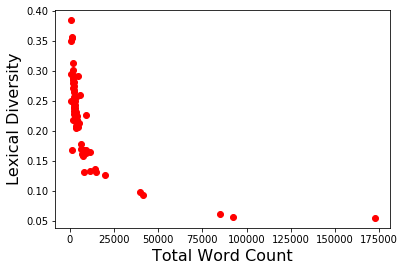

In [0]:
import matplotlib.pyplot  as plt

plt.plot(character_quotes_parameters_df['Total Word Count'], character_quotes_parameters_df['Lexical Diversity'],'ro')

plt.xlabel('Total Word Count', fontsize=16)
plt.ylabel('Lexical Diversity', fontsize=16)

plt.show()

An exponential decay maybe? Let's take the log of the variables:

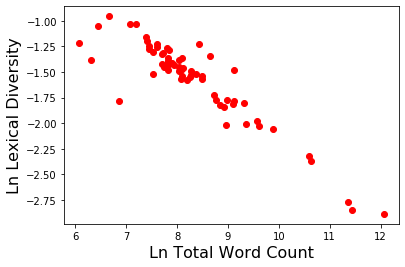

In [0]:
import matplotlib.pyplot  as plt
import math
plt.plot(np.log(character_quotes_parameters_df['Total Word Count'].astype(float)), np.log(character_quotes_parameters_df['Lexical Diversity'].astype(float)),'ro')

plt.xlabel('Ln Total Word Count', fontsize=16)
plt.ylabel('Ln Lexical Diversity', fontsize=16)

plt.show()

### Unique Word Count vs Total Word Count

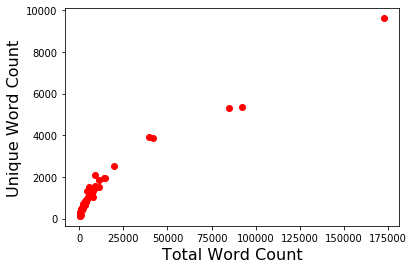

In [0]:
import matplotlib.pyplot  as plt

plt.plot(character_quotes_parameters_df['Total Word Count'], character_quotes_parameters_df['Unique Words'],'ro')

plt.xlabel('Total Word Count', fontsize=16)
plt.ylabel('Unique Word Count', fontsize=16)

plt.show()

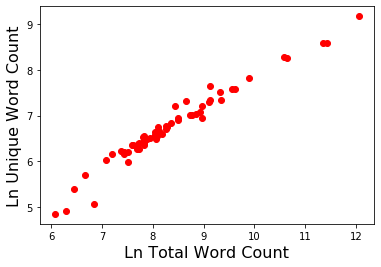

In [0]:
import matplotlib.pyplot  as plt

plt.plot(np.log(character_quotes_parameters_df['Total Word Count'].astype(float)), np.log(character_quotes_parameters_df['Unique Words'].astype(float)),'ro')

plt.xlabel('Ln Total Word Count', fontsize=16)
plt.ylabel('Ln Unique Word Count', fontsize=16)

plt.show()

Note: The log function in numpy is actually the natural log (ln), not the log to the base 10 or 2. I think it is amazing how this number can approximate growth in real life. So the relationship in here is that of a natural exponential growth.

## Word Frequencies

In [0]:
kyle_word_freq = nltk.FreqDist(kyle_tokens_list)

In [0]:
kyle_word_log_probability = [ {word: -log(float(count)/ len(kyle_tokens_list))} for word, count in kyle_word_freq.items() ]

In [0]:
kyle_word_log_probability[:10]

[{'going': 6.1870313306519575},
 {'away': 7.362833258011197},
 {'?': 3.5182170809143676},
 {'for': 5.304445125529194},
 {'how': 5.909399594053678},
 {'long': 8.019612794400267},
 {'draw': 11.351817304575471},
 {'two': 7.8254567799593096},
 {'card': 9.742379392141371},
 {',': 2.9084859617576893}]

## What are N-Grams?


Simply put n-grams are the progressive sets of n words from a given text. What do I mean by progressive? Well, n-grams are “selected” from text n at a time, and they overlap by n-1 words for each n-gram. As with most things this is more easily explained with an example.
For our purposes we will use the following sentence as our text: “The quick brown fox jumped over the lazy dog”


1-gram list (aka unigrams)
([“The”], [“quick”], [“brown”], [“fox”], [“jumped”], [“over”], [“the”], [“lazy”], [“dog”])


2-gram list (aka bigrams)
( [“The”, “quick”], [“quick”, “brown”], [“brown”, “fox”], [“fox”, “jumped”], [“jumped”, “over”], [“over”, “the”], [“the”, “lazy”], [“lazy”, “dog”])


As can be seen from the example above n-grams are generated in order by constructing lists of n-words. Where the n-words are selected starting from the first word in a text, index 0. Until you have an n-gram that contains the last word in the text. It’s best to think of this process as sliding a window “n-words wide” along your text as you get each n-gram.
What are n-grams used for?
N-grams are used in the creation of n-gram language models. The basic idea is that in natural language the next word that will be used is dependent upon the previous words. The statistical properties of n-grams can be exploited to generate probabilities for what the “next word” after a given set of words will be. This ability to give a probability for what the next word will be is the n-gram language model.

In [0]:
#Build n-gram builder
def build_ngram(text, n):
    #sanity check, but generally speaking we want the text to be much much longer than the sentence length to get
    #interesting\funny results
    if len(text) < n:
        print( "Text length is less than n")
        return text
    index = 0
    tokenized_text = nltk.word_tokenize(text)#Try it with lower case, i.e. text.lower()
    
    ngram = defaultdict()
    
    #Loop over all text, except the last n words, since they cannot have n words after
    for index in range(len(tokenized_text) - n):
        #Get current word from the corpus
        current_word = tokenized_text[index]
        
        #Get the next n words, so that we can push them into the current word's entry in the ngram dictionary
        ngram_tail = " ".join(tokenized_text[index + 1 : index+n])
        
        #The general structure of an entry is as follows: the beginning of the ngram is the key. Its contents is a dictionary
        #that contains the total number of grams that are started by this first word, plus another dictionary of all the grams
        #and their counts. To save a little space, only the tail is stored in that last dictionary. That way, we can compute 
        #easily the probability since everything needed is already stored inside
        
        #If this is a new entry, create a new one
        if current_word not in ngram.keys():
            ngram[current_word] = {
                                     'total_grams_start' : 1, 
                                     'grams':  { ngram_tail : 1  } 
                                   }
        else:
            #increase the total count of grams starting with this word
            ngram[current_word]['total_grams_start'] += 1
            #If this ngram tail is new, create a new sub-entry with this ngram
            if ngram_tail not in ngram[current_word]['grams'].keys():
                ngram[current_word]['grams'][ngram_tail] = 1
            #else, increment the entry count by one
            else:
                ngram[current_word]['grams'][ngram_tail] += 1

    return ngram

### Quote generation function


In [0]:
def Generate_quote(grammed_input, gram_size, start_word, quote_length):
    
    output_str = start_word
    
    #This is like the seed based on which we will pick the next word.
    current_word = start_word.lower()
    
    next_word = ""
    
    #iterate length by gram size times + 1. We want to iterate as much as needed to build a sentence of n size
    for i in range(quote_length//gram_size + 1):
        #We want some randomness in picking the next word, not just pick the highest probable next word. So we are going to
        #set a minimum probability under which the gram is not going to get picked.
        random_num = random.random()
        
        #cumulative probability
        cum_prob = 0
        for potential_next_word, count in grammed_input[current_word]['grams'].items():
            #The cumulative probability is the count of this gram-tail divided by how many time the see word appeared
            cum_prob += float(count)/grammed_input[current_word]['total_grams_start']
            #print cum_prob, random_num
            #If the cumulative probability has reached the minimum probability threshold, then this is the gram to use
            if cum_prob > random_num:
                output_str += ( " " + potential_next_word) 
                current_word = potential_next_word.split()[-1]
                break
            #else, i.e. this gram's probability is lower than our random threshold, get the next gram
            else:
                continue
    # finish with an end of sentence. For now, a sentence ends with a full stop, no question\exclamation marks.
    # The code will continue to generate text until we encounter a gram that ends with a full stop.
    if output_str[-1] != '.':
        #eos = end of sentence
        no_eos = True
        while no_eos:
            cum_prob = 0
            random_num = random.random()
            
            for potential_next_word, count in grammed_input[current_word]['grams'].items():
                cum_prob += float(count)/grammed_input[current_word]['total_grams_start']
                #print cum_prob, random_num
                if cum_prob > random_num:
                    if '.' in potential_next_word:
                        potential_next_word = potential_next_word.split('.')[0]
                        output_str += ( " " + potential_next_word + ".") 
                        no_eos = False
                    else:
                        output_str += ( " " + potential_next_word) 
                        current_word = potential_next_word.split()[-1]
                    break
                else:
                    continue
        
    return output_str

### Bigram (2-ngram)

In [0]:
Cartman_bigram = build_ngram(' '.join(Cartman_tokens_list), 2)

In [0]:
Generate_quote(Cartman_bigram, 2, 'i', 12)

"i 'll remember , fonics monkey out what 's a toilet paper than this tv , no es ist zeit für rache ! i grab your money with the blame the hell are real ."

Bigram outputs:

 - "i know , butters . he did a black people watch me getting material i wo n't want to get ahead of grosses me ."<br>
 -"i still think maybe we know a day of a sore loser kip drordy , you really got skidmarks monday she 's all ."<br>

Sounds funny, but it doesn't make a lot of sense. Let's try the trigram and see how this would improve:

### Trigrams

In [0]:
Cartman_trigram = build_ngram(' '.join(Cartman_tokens_list), 3)

In [0]:
Generate_quote(Cartman_trigram, 3, 'i', 12)

"i 'm not funny ! i should be fine . just , i did n't you tell anyone ! i can we , dog , i was gon na die in the depths of atlantis , and when we shoot george lucas ."

 -  "i do n't wan na stop feeling like i 'm looking for the olives ."<br>
 - "i 'll kick you in rancho de burritos rojos , south park ."<br>
 - "i see where have i like to do is exactly the border ! because i 'm trying to have another abortion , but mo-o-om , what a ninja when you can either give it back to our freedom ."<br>
 - 'i know . listen everybody at war , you think he has… no .'
 - "i do n't you ever since wendy psst . perhaps you doing with you and with all right , cupid me ! yes ."<br>


### Quadgrams:

In [0]:
Cartman_quadgram = build_ngram(' '.join(Cartman_tokens_list), 4)

In [0]:
Generate_quote(Cartman_quadgram, 4, 'i', 12)

"i can probably offer fabulous prizes if we find a cause and then the stores had seven hippies in the turkey ! we 'll all ! he 's that asshole who crapped him pants ! well , we can set a diversion on butter 's chin ."

 - '"i do n't see the ... car , please . nononono , you ripped off our dear savior 's anatomy ? ! you totally saved my life , then why am the awesom-o 4000 ? but mom ! must go fudge yourself , dude ."<br>
 - "i 'm going to mr. garrison right . '' all out ! wait ."<br>
 -"i care so much longer . i did n't read what 's in your town ."<br>
 - "i ? '' because they do n't start with me . is anybody on my propertih , and i do n't even though it did n't mean to freeze ! no ."<br>
 - 'i will ! yeah , may be able to put rules on toilet-time like that .'

### Pentgrams:

In [0]:
Cartman_pentgram = build_ngram(' '.join(Cartman_tokens_list), 5)

In [0]:
Generate_quote(Cartman_pentgram, 5, 'i', 12)

"i pulled down his pants ? you son of forced entry . we gon na do ? you 're what ? sucky-sucky ? what are assholes ! grow up a kidney ."

 - "i am never sucking your wiener in his mouth , and i 've got the doll ! they got it working on our school project the movies on cartman ! goddammit cartman , check it out ."<br>
 - "i ca n't stop feeling this might be the fuck is wrong with a pig ."<br>
 - "i do n't believe it , that was n't gon na work now go fund yourself ."
 - "i guess . look , it 's true . i wan na be cool ."<br>
 - "i am not , not scary , fatass ! so that 's why bad ? because they doing thiiis ? ! and what the hell is wrong with them ! hello , everybodyyy ."

 A Richer Corpus can create nicer sentences definately, that we what we learnt from other online code and github repositories we found.

# Findings

We observed the following points:<br>

Larger number of grams will result in:<br>
  - Much greater time period so one has to be careful of the corpus they give to the program. We would typically not run a whole book<br>
  - The more the sentences are going to be exact copies from the original text. So using a 12-gram to generate a sentence of length of 12 can give back an original sentence, unchanged (The only variation is from the random number generated to pick the next word).


## References:
1. https://www.kaggle.com/tovarischsukhov/southparklines
2. https://web.stanford.edu/~jurafsky/slp3/3.pdf
3. https://www.kaggle.com/currie32/a-south-park-chatbot
4. https://www.kaggle.com/tovarischsukhov/predicting-speaker
5. https://www.kaggle.com/etakla/quote-generator-a-silicone-based-parrot
